# Classification of Faces

In this excercise, we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". The data is from a random sample of 8 persons of the OXFORD VGG Face dataset, more information here: http://www.robots.ox.ac.uk/~vgg/data/vgg_face/.

## Downloading of Data

You can download the data using the following code:

In [1]:
import gzip, urllib, os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.utils import to_categorical
from keras import regularizers

!pip install h5py
import h5py

keras.__version__

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'2.3.1'

In [2]:
# Get path to where datasets are saved
BASE_PATH = os.path.join(os.getcwd(), "..", "datasets")
print("Directory: " + BASE_PATH)
print("Existing Sub-Directories: " + str(os.listdir(BASE_PATH)))

# Directory/File where data is saved in
DS_DIR = os.path.join(BASE_PATH, "8_faces")
FILE_PATH_TRAIN = os.path.join(DS_DIR, "8_faces_train_and_valid.hdf5")

# Load File if not already existent in dataset directory
if not os.path.isfile(FILE_PATH_TRAIN):
    print("Request data")
    os.mkdir(DS_DIR)
    url = "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1"
    urllib.request.urlretrieve(url, FILE_PATH_TRAIN)
    print("Loaded file")
    
    
print("Files: " + str(os.listdir(DS_DIR)))

Directory: /home/jovyan/work/../datasets
Existing Sub-Directories: ['8_faces', 'MNIST']
Files: ['8_faces_train_and_valid.hdf5', '8_faces_test.hdf5']


In [3]:
# Check values
h5f_X = h5py.File(FILE_PATH_TRAIN, 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces'].value
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces'].value
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces'].value
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces'].value
print(Y_valid.shape, X_valid.dtype)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']


/opt/conda/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,) float64


250


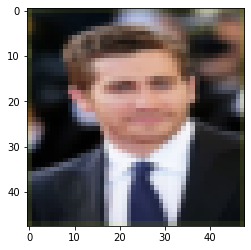

In [4]:
n = 0 #Miranda Cosgrove
n = 1 #Chris Martin (singer)
n = 2 #Emma Stone (actress)
n = 3 #Jamie Foxx (actor)
n = 4 #Steve Jobs (entrepreneur)
n = 5 #Zac Efron (actor)
n = 6 #Sandra Oh (actress)
n = 7 #Taryn Manning (actress)
n = 1
idx=np.reshape(np.where(Y_train[0:len(Y_train)]==n),(250))
print(len(Y_train[idx]))
plt.imshow(np.asarray(X_train[idx][0],dtype="uint8"))

In [5]:
FILE_PATH_TEST = os.path.join(DS_DIR, '8_faces_test.hdf5')

#Downloading the data, if it does not exist
if not os.path.isfile(FILE_PATH_TEST):
    print("Load test-files")
    url = "https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1"
    urllib.request.urlretrieve(url, FILE_PATH_TEST)
    print("Test files loaded")

# Check values
h5f_X = h5py.File(FILE_PATH_TEST, 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces'].value
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces'].value
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


In [6]:
np.min(X_train),np.max(X_train),np.min(X_test),np.max(X_test)
X_train /= 255
X_valid /= 255
X_test /= 255

### Playing around with the data

In [7]:
print("Train-Samples: " + str(X_train.shape[0]))
print("X-Training: " + str(X_train.shape))
print("Y-Training: " + str(Y_train.shape))

print("\n------------\nTest-Samples: " + str(X_test.shape[0]))
print("X-Test: " + str(X_test.shape))
print("Y-Test: " + str(Y_test.shape))

Train-Samples: 2000
X-Training: (2000, 48, 48, 3)
Y-Training: (2000,)

------------
Test-Samples: 400
X-Test: (400, 48, 48, 3)
Y-Test: (400,)


## a) Training an CNN from scratch

Train a model (as shown below) from scratch, using the training data for training and the validation data for validation. For all activations in the hidden layer use the 'ReLU', for the last layer use softmax. Use 3x3 convolutions and use padding = same.

- [x] Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy. 
- [x] Calculate the accuracy on the test set (you should reach an accuracy of about 0.54)
- [x] Calculate the confusion matrix
- [ ] Have a look at missclassified examples

Image of the network:
https://github.com/ioskn/mldl_htwg/blob/master/uebungen/dl_cnn_faces_net.png

In [8]:
class_labels = {
    0: "Miranda Cosgrove",
    1: "Chris Martin",
    2: "Emma Stone",
    3: "Jamie Foxx",
    4: "Steve Jobs",
    5: "Zac Efron",
    6: "Sandra Oh",
    7: "Taryn Manning"
}

In [9]:
Y_train_encoded = to_categorical(Y_train)
Y_train_encoded.shape

(2000, 8)

In [10]:
model = Sequential()

# Input layer
model.add(Conv2D(5, (3, 3), input_shape= (48, 48, 3), padding = "same", activation = "relu"))

# Hidden layers
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(15, (3, 3), padding = "same", activation = "relu"))
model.add(MaxPooling2D((5,5)))
model.add(Conv2D(20, (3, 3), padding = "same", activation = "relu"))

# Output-layer
model.add(Flatten())
model.add(Dense(len(class_labels.keys()), input_shape=(8,), activation = "softmax",  activity_regularizer = regularizers.l2(.01)))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 5)         140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 15)        690       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 15)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 20)          2720      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)               

In [11]:
# Compile & train model
optim = optimizers.SGD(learning_rate = .05, momentum = .95)
model.compile(optimizer = optim, loss = "categorical_crossentropy", metrics = ["acc"])

# model.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["acc"])
history = model.fit(X_train, Y_train_encoded, epochs = 40, batch_size = 250)


Epoch 1/40
2000/2000 [==============================] - 2s 932us/step - loss: 2.3934 - acc: 0.1355
Epoch 2/40
2000/2000 [==============================] - 1s 593us/step - loss: 2.3858 - acc: 0.1720
Epoch 3/40
2000/2000 [==============================] - 1s 616us/step - loss: 2.3737 - acc: 0.1845
Epoch 4/40
2000/2000 [==============================] - 1s 685us/step - loss: 2.3468 - acc: 0.2265
Epoch 5/40
2000/2000 [==============================] - 1s 582us/step - loss: 2.3085 - acc: 0.2535
Epoch 6/40
2000/2000 [==============================] - 1s 640us/step - loss: 2.2892 - acc: 0.2695
Epoch 7/40
2000/2000 [==============================] - 2s 903us/step - loss: 2.2334 - acc: 0.3135
Epoch 8/40
2000/2000 [==============================] - 2s 942us/step - loss: 2.2064 - acc: 0.3465
Epoch 9/40
2000/2000 [==============================] - 2s 819us/step - loss: 2.1530 - acc: 0.3800
Epoch 10/40
2000/2000 [==============================] - 2s 1ms/step - loss: 2.1109 - acc: 0.4200
Epoch 11/4

In [12]:
Y_test_encoded = to_categorical(Y_test)
model.evaluate(X_test, Y_test_encoded)

400/400 [==============================] - 0s 883us/step


[1.4014838743209839, 0.5649999976158142]

In [13]:
def print_learning_curves(history):
    fig = plt.figure(figsize = (20,8))
    plt.subplot(121)
    plt.title("Accuracy")
    plt.plot(history.history["acc"])
    plt.subplot(122)
    plt.title("Loss")
    plt.plot(history.history["loss"])

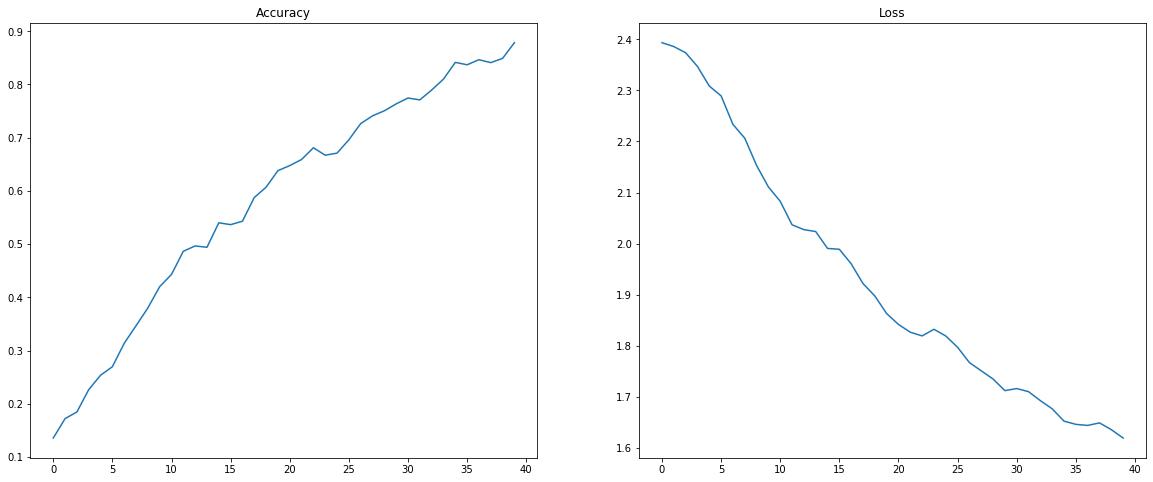

In [14]:
print_learning_curves(history)

In [15]:
y_pred = model.predict(X_test)
y_pred

array([[0.01183844, 0.7574305 , 0.00251252, ..., 0.11213939, 0.02229173,
        0.06693145],
       [0.01951408, 0.16798024, 0.03342298, ..., 0.10291624, 0.02135235,
        0.09622575],
       [0.01803708, 0.05454434, 0.37195608, ..., 0.03537156, 0.03461269,
        0.37103856],
       ...,
       [0.00947738, 0.6802288 , 0.00669287, ..., 0.21501428, 0.01101796,
        0.03144938],
       [0.4129089 , 0.09990767, 0.34704524, ..., 0.03465463, 0.02391725,
        0.06787111],
       [0.41803858, 0.01403001, 0.05144097, ..., 0.07684105, 0.38346955,
        0.03707315]], dtype=float32)

In [16]:
pred_lable_indices = np.argmax(y_pred, axis = 1)
print(pred_lable_indices.shape)
print(Y_test.shape)

(400,)
(400,)


In [17]:
def show_confusion(y_predicted, y_true):
    con_mat = confusion_matrix(y_predicted, y_true)
    plt.figure(figsize = (8, 6))
    ax = sns.heatmap(con_mat, annot = True, cmap = plt.cm.Blues)
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + .5, top - .5)
    plt.show()
    plt.tight_layout()

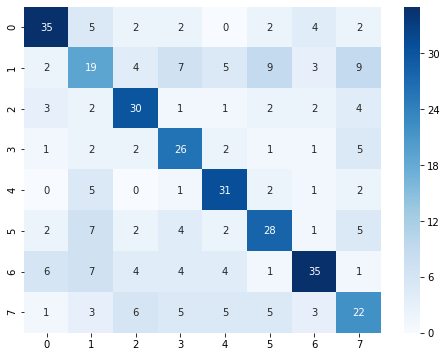

<Figure size 432x288 with 0 Axes>

In [18]:
show_confusion(pred_lable_indices, Y_test)

In [19]:
def plot_imgs(imgs, max_per_row = 4):
    """
        Prints array of images.
    """
    
    sample_count = imgs.shape[0]
    
    fig = plt.figure(figsize = (20,20))
    
    columns = max_per_row if isinstance(max_per_row, int) else 4
    rows = sample_count
    
    for i in range(sample_count):
        plt.subplot(rows,columns,i+1)
        plt.imshow(imgs[i])
    

In [20]:
def show_wrong_classified(x, y_pred, y_true):
    """
        Select and show random wrong classified images.
    """
    
    mis_classified = np.where(y_pred != y_true)[0]
    
    random_mis_cl_indx = np.random.choice(len(mis_classified), 10)
    mis_img = X_test[random_mis_cl_indx]
    
    plot_imgs(mis_img)

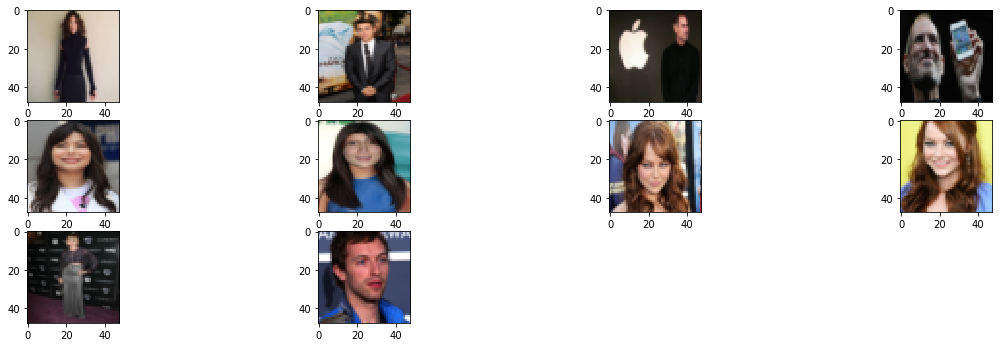

In [21]:
show_wrong_classified(X_train, pred_lable_indices, Y_test)

## b) Training using transfer learning
In transfer learning you use an existing trained model with given weights trained on a different task. You then add a few layers yourself and only train them. The model you add should look like:

```
my_dense1 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense2 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense3 (Dense)            (None, 100)               51300     
_________________________________________________________________
my_dense4 (Dense)            (None, 8)                 808       
```

Use the following code as a starting point:

In [22]:
from keras.applications import VGG16
img_height = img_width = 48
base_model = VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))

58892288/58889256 [==============================] - 120s 2us/step


In [36]:
fc1 = base_model.output
fc1 = Flatten()(fc1)

fc1 = Dense(512, activation = "relu", name = "my_dense1")(fc1)
fc1 = Dense(512, activation = "relu", name = "my_dense2")(fc1)
fc1 = Dense(100, activation = "relu", name = "my_dense3")(fc1)

fc1 = Dense(8,activation='softmax', name='my_dense4')(fc1)
model_trans = keras.Model(base_model.input, fc1) #Current hack for TF 2.0 and keras
model_trans.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [37]:
for layer in model_trans.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
    print(name)
  else:
    layer.trainable = False

my_dense1
my_dense2
my_dense3
my_dense4


In [39]:
model_trans.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["acc"])
history = model_trans.fit(X_train, Y_train_encoded, epochs = 10, batch_size = 500)

Epoch 1/10
2000/2000 [==============================] - 33s 17ms/step - loss: 2.0298 - acc: 0.2340
Epoch 2/10
2000/2000 [==============================] - 38s 19ms/step - loss: 2.0172 - acc: 0.2525
Epoch 3/10
2000/2000 [==============================] - 43s 22ms/step - loss: 2.0042 - acc: 0.2755
Epoch 4/10
2000/2000 [==============================] - 42s 21ms/step - loss: 1.9925 - acc: 0.2840
Epoch 5/10
2000/2000 [==============================] - 44s 22ms/step - loss: 1.9799 - acc: 0.2880
Epoch 6/10
2000/2000 [==============================] - 43s 22ms/step - loss: 1.9692 - acc: 0.2995
Epoch 7/10
2000/2000 [==============================] - 40s 20ms/step - loss: 1.9573 - acc: 0.3110
Epoch 8/10
2000/2000 [==============================] - 38s 19ms/step - loss: 1.9468 - acc: 0.3195
Epoch 9/10
2000/2000 [==============================] - 39s 20ms/step - loss: 1.9354 - acc: 0.3360
Epoch 10/10
2000/2000 [==============================] - 46s 23ms/step - loss: 1.9259 - acc: 0.3340


In [26]:
model_trans.evaluate(X_test, Y_test_encoded)

400/400 [==============================] - 9s 23ms/step


[1.647254981994629, 0.4300000071525574]

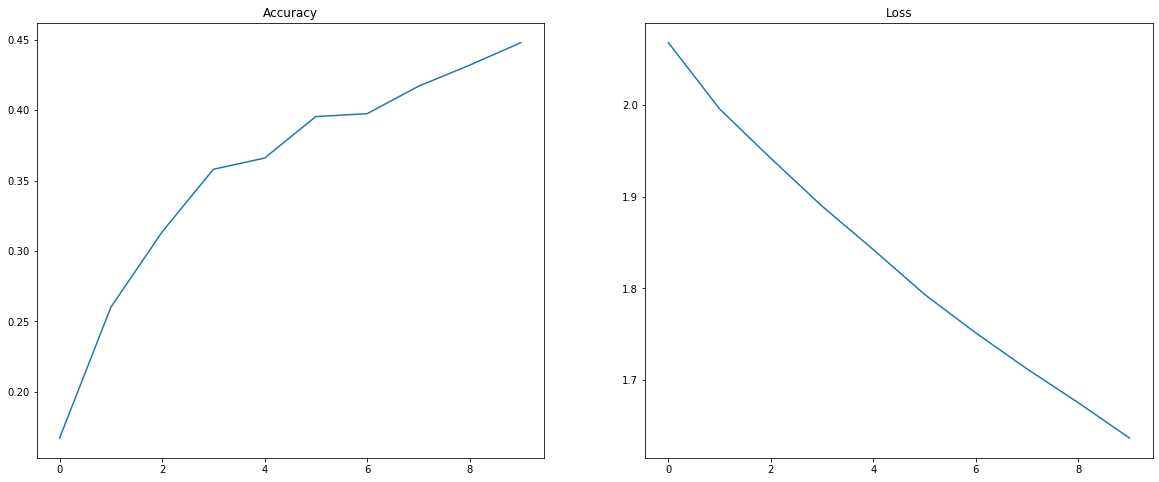

In [27]:
print_learning_curves(history)

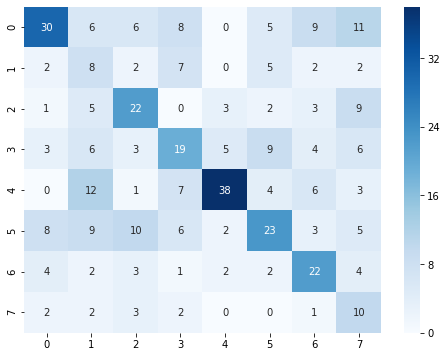

<Figure size 432x288 with 0 Axes>

In [28]:
y_pred = np.argmax(model_trans.predict(X_test), axis = 1)
show_confusion(y_pred, Y_test)

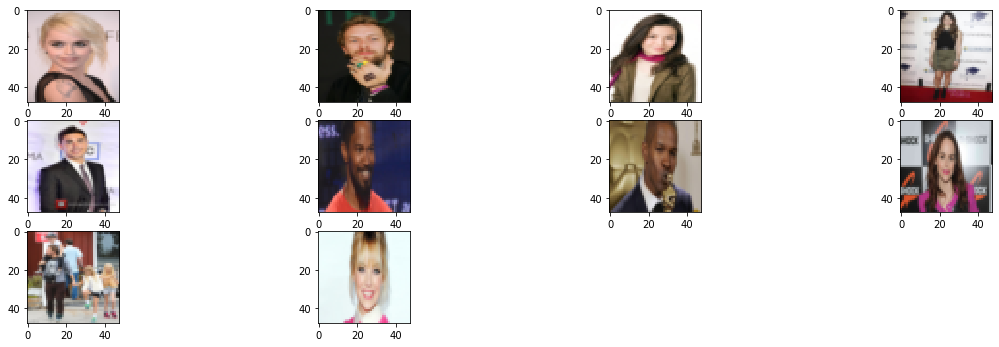

In [29]:
show_wrong_classified(X_test, y_pred, Y_test)

Do the same analysis as in a) above. You should get an accuracy of approx 0.61

## c) Try to get better.

Ideas: use dropout and other tricks to prevent overfitting. Try to learn some convulutional layers as well.

In [72]:
fc1 = base_model.output
fc1 = Flatten()(fc1)

fc1 = Dropout(0.2)(fc1)
fc1 = Dense(512, activation = "relu", name = "my_dense1")(fc1)
fc1 = Dropout(0.2)(fc1)
fc1 = Dense(256, activation = "relu", name = "my_dense2")(fc1)
fc1 = Dropout(0.3)(fc1)
fc1 = Dense(10, activation = "tanh", name = "my_dense3")(fc1)

# fc1 = Conv1D(10, (5))(fc1)

fc1 = Dense(8, activation='softmax', name='output_dense', activity_regularizer = regularizers.l2(0.4))(fc1)
trans_model = keras.Model(base_model.input, fc1) #Current hack for TF 2.0 and keras
trans_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0  

In [73]:
for layer in trans_model.layers:
    name = layer.name
    if name.startswith("my"):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
optim = optimizers.SGD(lr = .08, momentum = 0.9)
model_trans.compile(optimizer = optim, loss = "categorical_crossentropy", metrics=["acc"])
history = model_trans.fit(X_train, Y_train_encoded, epochs = 10, batch_size = 250)

Epoch 1/10
2000/2000 [==============================] - 42s 21ms/step - loss: 1.9557 - acc: 0.2560
Epoch 2/10
1250/2000 [=================>............] - ETA: 16s - loss: 1.8274 - acc: 0.3016

In [ ]:
model.evaluate(X_test, Y_test_encoded)

In [ ]:
print_learning_curves(history)

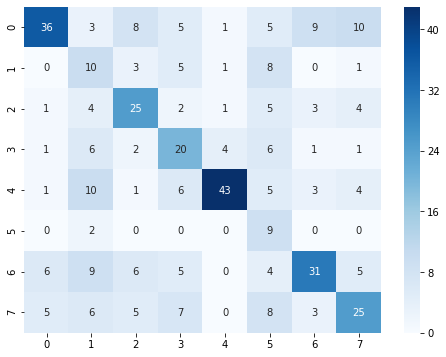

<Figure size 432x288 with 0 Axes>

In [55]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
show_confusion(y_pred, Y_test)